In [27]:
import numpy as np

### Import Signal and Array

`signal.py` defines some commonly used signal types in DOA estimation. Each signal type is a class that inherits from the base class `Signal`. These classes are used to generate incident signals.  
`array.py` defines some commonly used array structures. Each array structure is a class that inherits from the base class `Array`. The `Array` class uses the signals generated by the `Signal` class and the incident angles to generate simulated data for the received signals of the array.


In [28]:
from doa_py.arrays import UniformLinearArray
from doa_py.signals import MixedSignal

### Simulation Parameter Configuration

Define simulation parameters related to array structure, signal parameters, and incident direction to generate sampled array received signals.


In [46]:
# signal parameters
angle_incidence = np.array([0, 30])
num_snapshots = 1000
fre_min = 1e6
fre_max = 1e7
fs = 2.5e7
snr = 0

num_antennas = 16
antenna_spacing = 0.5 * (
    3e8 / fre_max
)  # set to half wavelength of highest frequency

num_narrowband = 1

### Simulation Signal Generation

Instantiate `Array` and `Signal` and generate simulated data of array received signals.


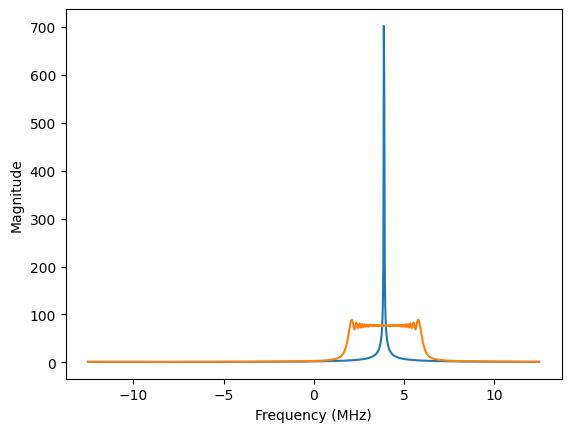

In [47]:
import matplotlib.pyplot as plt

# generate signal and received data
signal = MixedSignal(f_min=fre_min, f_max=fre_max, fs=fs, base="chirp")

array = UniformLinearArray(m=num_antennas, dd=antenna_spacing)

# plot the signal in the frequency domain
plt.plot(
    np.fft.fftshift(np.fft.fftfreq(num_snapshots, 1 / fs)) / 1e6,
    np.abs(
        np.fft.fftshift(
            np.fft.fft(
                signal.gen(
                    n=len(angle_incidence),
                    nsamples=num_snapshots,
                    m=num_narrowband,
                    narrow_idx=[1],
                )
            )
        )
    ).transpose(),
)
plt.xlabel("Frequency (MHz)")
plt.ylabel("Magnitude")

received_data = array.received_signal(
    signal=signal,
    angle_incidence=angle_incidence,
    snr=snr,
    nsamples=num_snapshots,
    use_cache=True,
    calc_method="delay",
    m=num_narrowband,
    narrow_idx=[1],
)


### Incident Angle Estimation

Several classical DOA estimation algorithms are defined in the `algorithm` package, some of which will output the spatial spectrum, and some of which will directly output the estimated incident angle value.
So we first import two plotting functions, which are used to show the estimation results of these two algorithms.


In [36]:
from doa_py.plot import plot_spatial_spectrum

#### IMUSIC Alogrithm


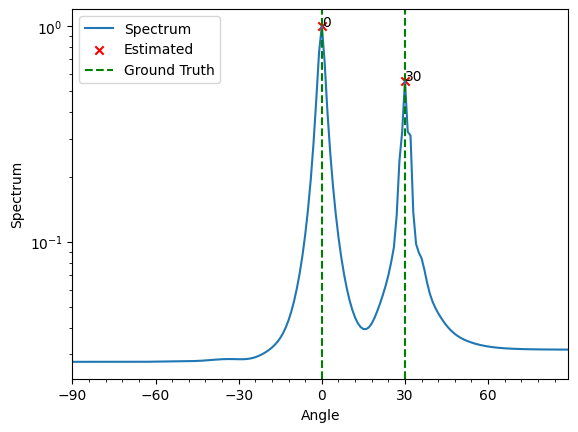

In [48]:
from doa_py.algorithm import imusic

search_grids = np.arange(-90, 90, 1)

num_signal = len(angle_incidence)
spectrum = imusic(
    received_data=received_data,
    num_signal=num_signal,
    array=array,
    fs=fs,
    angle_grids=search_grids,
    num_groups=16,
    f_min=signal.f_min,
    f_max=signal.f_max,
    n_fft_min=128,
    unit="deg",
)

plot_spatial_spectrum(
    spectrum=spectrum,
    ground_truth=angle_incidence,
    angle_grids=search_grids,
    num_signal=num_signal,
)

#### CSSM Algorithm


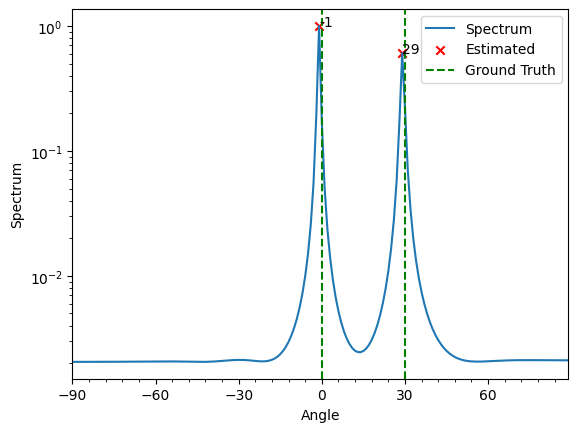

In [50]:
from doa_py.algorithm import cssm

search_grids = np.arange(-90, 90, 1)

num_signal = len(angle_incidence)
spectrum = cssm(
    received_data=received_data,
    num_signal=num_signal,
    array=array,
    fs=fs,
    angle_grids=search_grids,
    pre_estimate=np.array([-1, 29]),
    unit="deg",
)

plot_spatial_spectrum(
    spectrum=spectrum,
    ground_truth=angle_incidence,
    angle_grids=search_grids,
    num_signal=num_signal,
)

#### TOPS Algorithm


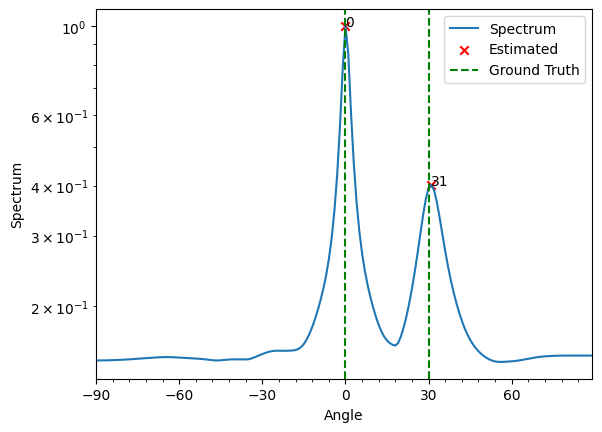

In [59]:
from doa_py.algorithm import tops

search_grids = np.arange(-90, 90, 1)

num_signal = len(angle_incidence)
spectrum = tops(
    received_data=received_data,
    num_signal=num_signal,
    array=array,
    fs=fs,
    num_groups=32,
    angle_grids=search_grids,
    unit="deg",
)

plot_spatial_spectrum(
    spectrum=spectrum,
    ground_truth=angle_incidence,
    angle_grids=search_grids,
    num_signal=num_signal,
)